In [1]:
%cd ~/repo/protein-transfer

/home/t-fli/repo/protein-transfer


In [2]:
%load_ext blackcellmagic

In [11]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

In [4]:
from scr.preprocess.data_process import ProtranDataset
from scr.encoding.encoding_classes import ESMEncoder


In [8]:
from scr.params.train_test import *

In [6]:
from scr.model.pytorch_model import LinearRegression

In [5]:
encoder = ESMEncoder

In [41]:
model = LinearRegression(input_dim=1280, output_dim=1)
model.to(DEVICE)
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.MSELoss()
criterion.to(DEVICE, non_blocking=True)

MSELoss()

In [16]:
dataset_path="data/proeng/gb1/two_vs_rest.pkl"

In [56]:
[True if subset == "train" else False for subset in ["test"]] 

[False]

In [48]:
def get_split_loader(
    dataset_path: str,
    subset_list: list[str] = ["train", "val"],
    encoder_class=ESMEncoder,
    encoder_name="esm1b_t33_650M_UR50S",
    embed_layer=0,
    embed_batch_size=32,
    flatten_emb="mean",
    embed_path=None,
    seq_start_idx = False,
    seq_end_idx = False,
    loader_batch_size=32,
    worker_seed=42,
    **encoder_params
):

    if_shuffle_list = [True if subset == "train" else False for subset in subset_list]

    return (
        DataLoader(
            dataset=ProtranDataset(
                dataset_path=dataset_path,
                subset=subset,
                encoder_class=encoder_class,
                encoder_name=encoder_name,
                embed_layer=embed_layer,
                embed_batch_size=embed_batch_size,
                flatten_emb=flatten_emb,
                embed_path=embed_path,
                seq_start_idx=seq_start_idx,
                seq_end_idx=seq_end_idx,
                **encoder_params
            ),
            batch_size=loader_batch_size,
            shuffle=if_shuffle,
            worker_init_fn=worker_seed,
        )
        for subset, if_shuffle in zip(subset_list, if_shuffle_list)
    )

In [25]:
"""Pre-processing the dataset"""

from __future__ import annotations

from collections import Sequence

import os
from glob import glob
import pandas as pd
import numpy as np

import torch
from torch.utils.data import Dataset

from scr.utils import pickle_save, pickle_load, replace_ext
from scr.preprocess.seq_loader import SeqLoader
from scr.encoding.encoding_classes import AbstractEncoder


def get_mut_name(mut_seq: str, parent_seq: str) -> str:
    """
    A function for returning the mutant name

    Args:
    - mut_seq: str, the full mutant sequence
    - parent_seq: str, the full parent sequence

    Returns:
    - str, parent, indel, or mutant name in the format of
        ParentAAMutLocMutAA:ParentAAMutLocMutAA:..., ie. W39W:D40G:G41C:V54Q
    """

    mut_list = []
    if parent_seq == mut_seq:
        return "parent"
    elif len(parent_seq) == len(mut_seq):
        for i, (p, m) in enumerate(zip(list(parent_seq), list(mut_seq))):
            if p != m:
                mut_list.append(f"{p}{i+1}{m}")
        return ":".join(mut_list)
    else:
        return "indel"


class AddMutInfo:
    """A class for appending mutation info for mainly protein engineering tasks"""

    def __init__(self, parent_seq_path: str, csv_path: str):

        # Load the parent sequence from the fasta file
        self._parent_seq = SeqLoader(parent_seq_path=parent_seq_path)

        # load the dataframe
        self._init_df = pd.read_csv(csv_path)

        self._df = self._init_df.copy()
        # add a column with the mutant names
        self._df["mut_name"] = self._init_df["sequence"].apply(
            get_mut_name, parent_seq=self._parent_seq
        )
        # add a column with the number of mutations
        self._df["mut_numb"] = (
            self._df["mut_name"].str.split(":").map(len, na_action="ignore")
        )

        # get the pickle file path
        self._pkl_path = replace_ext(input_path=csv_path, ext=".pkl")

        pickle_save(what2save=self._df, where2save=self._pkl_path)

    @property
    def parent_seq(self) -> str:
        """Return the parent sequence"""
        return self._parent_seq

    @property
    def pkl_path(self) -> str:
        """Return the pkl file path for the processed dataframe"""
        return self._pkl_path

    @property
    def df(self) -> pd.DataFrame:
        """Return the processed dataframe"""
        return self._df


class TaskProcess:
    """A class for handling different downstream tasks"""

    def __init__(self, data_folder: str = "data/"):
        """
        Args:
        - data_folder: str, a folder path with all the tasks as subfolders where
            all the subfolders have datasets as the subsubfolders, ie

            {data_folder}/
                proeng/
                    aav/
                        one_vs_many.csv
                        two_vs_many.csv
                        P03135.fasta
                    thermo/
                        mixed.csv
        """

        if data_folder[-1] == "/":
            self._data_folder = data_folder
        else:
            self._data_folder = data_folder + "/"

        # sumamarize all files i nthe data folder
        self._sum_file_df = self.sum_files()

    def sum_files(self) -> pd.DataFrame:
        """
        Summarize all files in the data folder

        Returns:
        - A dataframe with "task", "dataset", "split", "csv_path", "fasta_path", "pkl_path" as columns, ie.
            (proeng, gb1, low_vs_high, data/proeng/gb1/low_vs_high.csv, data/proeng/gb1/5LDE_1.fasta)
            note that csv_path is the list of lmdb files for the structure task
        """
        dataset_folders = glob(f"{self._data_folder}*/*")
        # need a list of tuples in the order of:
        # (task, dataset, split, csv_path, fasta_path)
        list_for_df = []
        for dataset_folder in dataset_folders:
            _, task, dataset = dataset_folder.split("/")
            if task == "structure":
                structure_file_list = [
                    file_path
                    for file_path in glob(f"{dataset_folder}/*.*")
                    if os.path.basename(os.path.splitext(file_path)[0]).split("_")[-1]
                    in ["train", "valid", "cb513"]
                ]
                list_for_df.append(
                    tuple([task, dataset, "cb513", structure_file_list, "", ""])
                )
            else:
                csv_paths = glob(f"{dataset_folder}/*.csv")
                fasta_paths = glob(f"{dataset_folder}/*.fasta")
                pkl_paths = glob(f"{dataset_folder}/*.pkl")

                assert len(csv_paths) >= 1, "Less than one csv"
                assert len(fasta_paths) <= 1, "More than one fasta"

                for csv_path in csv_paths:
                    # if parent seq fasta exists
                    if len(fasta_paths) == 1:
                        fasta_path = fasta_paths[0]

                        # if no existing pkl file, generate and save
                        if len(pkl_paths) == 0:
                            print(f"Adding mutation info to {csv_path}...")
                            pkl_path = AddMutInfo(
                                parent_seq_path=fasta_path, csv_path=csv_path
                            ).pkl_path
                        # pkl file exits
                        else:
                            pkl_path = replace_ext(input_path=csv_path, ext=".pkl")
                    # no parent fasta no pkl file
                    else:
                        fasta_path = ""
                        pkl_path = ""

                    list_for_df.append(
                        tuple(
                            [
                                task,
                                dataset,
                                os.path.basename(os.path.splitext(csv_path)[0]),
                                csv_path,
                                fasta_path,
                                pkl_path,
                            ]
                        )
                    )

        return pd.DataFrame(
            list_for_df,
            columns=["task", "dataset", "split", "csv_path", "fasta_path", "pkl_path"],
        )

    @property
    def sum_file_df(self) -> pd.DataFrame:
        """A summary table for all files in the data folder"""
        return self._sum_file_df


class ProtranDataset(Dataset):

    """A dataset class for processing protein transfer data"""

    def __init__(
        self,
        dataset_path: str,
        subset: str,
        encoder_class: AbstractEncoder,
        encoder_name: str,
        embed_layer: int,
        embed_batch_size: int = 0,
        flatten_emb: bool | str = False,
        embed_path: str = None,
        seq_start_idx: bool | int = False,
        seq_end_idx: bool | int = False,
        **encoder_params,
    ):

        """
        Args:
        - dataset_path: str, full path to the dataset, in pkl or panda readable format
            columns include: sequence, target, set, validation, mut_name (optional), mut_numb (optional)
        - subset: str, train, val, test
        - encoder_class: AbstractEncoder, the encoder class
        - encoder_name: str, the name of the encoder
        - embed_layer: int, the layer number of the embedding
        - embed_batch_size: int, set to 0 to encode all in a single batch
        - flatten_emb: bool or str, if and how (one of ["max", "mean"]) to flatten the embedding
        - embed_path: str = None, path to presaved embedding
        - seq_start_idx: bool | int = False, the index for the start of the sequence
        - seq_end_idx: bool | int = False, the index for the end of the sequence
        - encoder_params: kwarg, additional parameters for encoding
        """

        # with additional info mut_name, mut_numb
        if os.path.splitext(dataset_path)[-1] in [".pkl", ".PKL", ""]:
            self._df = pickle_load(dataset_path)
            self._add_mut_info = True
        # without such info
        else:
            self._df = pd.read_csv(dataset_path)
            self._add_mut_info = False

        assert "set" in self._df.columns, f"set is not a column in {dataset_path}"
        assert (
            "validation" in self._df.columns
        ), f"validation is not a column in {dataset_path}"

        self._df_train = self._df.loc[
            (self._df["set"] == "train") & (self._df["validation"] != True)
        ]
        self._df_val = self._df.loc[
            (self._df["set"] == "train") & (self._df["validation"] == True)
        ]
        self._df_test = self._df.loc[(self._df["set"] == "test")]

        self._df_dict = {
            "train": self._df_train,
            "val": self._df_val,
            "test": self._df_test,
        }

        assert subset in list(
            self._df_dict.keys()
        ), "split can only be 'train', 'val', or 'test'"
        self._subset = subset

        self._subdf_len = len(self._df_dict[self._subset])

        # not specified seq start will be from 0
        if seq_start_idx == False:
            self._seq_start_idx = 0
        else:
            self._seq_start_idx = seq_start_idx
        # not specified seq end will be the full sequence length
        if seq_end_idx == False:
            self._seq_end_idx = -1
        else:
            self._seq_end_idx = seq_end_idx

        # get unencoded string of input sequence
        # will need to convert data type
        self.sequence = self._get_column_value("sequence")

        # check if pregenerated embedding
        if embed_path is not None:
            print(f"Loading pregenerated embeddings from {embed_path}")
            encoded_sequences = pickle_load(embed_path)

        # encode the sequences without the mut_name
        else:
            encoded_sequences = []

            for x in encoder_class(
                encoder_name=encoder_name, embed_layer=embed_layer
            ).encode(
                mut_seqs=self.sequence,
                batch_size=embed_batch_size,
                flatten_emb=flatten_emb,
                **encoder_params,
            ):
                encoded_sequences.append(x)

        self.x = torch.tensor(np.vstack(encoded_sequences), dtype=torch.float32)

        # get and format the fitness or secondary structure values
        # can be numbers or string
        # will need to convert data type
        # make 1D tensor 2D
        self.y = np.expand_dims(self._get_column_value("target"), 1)

        # add mut_name and mut_numb for relevant proeng datasets
        if self._add_mut_info:
            self.mut_name = self._get_column_value("mut_name")
            self.mut_numb = self._get_column_value("mut_numb")
        else:
            self.mut_name = [""] * self._subdf_len
            self.mut_numb = [np.nan] * self._subdf_len

    def __len__(self):
        """Return the length of the selected subset of the dataframe"""
        return self._subdf_len

    def __getitem__(self, idx: int):

        """
        Return the item in the order of
        encoded sequence (x), target (y), sequence, mut_name (optional), mut_numb (optional)
        """

        return (
            self.x[idx],
            self.y[idx],
            self.sequence[idx],
            self.mut_name[idx],
            self.mut_numb[idx],
        )

    def _get_column_value(self, column_name: str) -> np.ndarray:
        """
        Check and return the column values of the selected dataframe subset
        """
        if column_name in self._df.columns:
            if column_name == "sequence":
                return (
                    self._df_dict[self._subset][column_name]
                    .str[self._seq_start_idx : self._seq_end_idx]
                    .values
                )
            else:
                return self._df_dict[self._subset][column_name].values

    @property
    def df_full(self) -> pd.DataFrame:
        """Return the full loaded dataset"""
        return self._df

    @property
    def df_train(self) -> pd.DataFrame:
        """Return the dataset for training only"""
        return self._df_train

    @property
    def df_val(self) -> pd.DataFrame:
        """Return the dataset for validation only"""
        return self._df_val

    @property
    def df_test(self) -> pd.DataFrame:
        """Return the dataset for training only"""
        return self._df_test

In [49]:
train_loader, val_loader = get_split_loader(dataset_path, subset_list = ["train", "val"])

Loading esm1b_t33_650M_UR50S using 0 layer embedding


Using cache found in /home/t-fli/.cache/torch/hub/facebookresearch_esm_main
100%|██████████| 12/12 [05:47<00:00, 28.96s/it]
Using cache found in /home/t-fli/.cache/torch/hub/facebookresearch_esm_main


Loading esm1b_t33_650M_UR50S using 0 layer embedding


100%|██████████| 2/2 [00:29<00:00, 14.57s/it]


In [30]:
from __future__ import annotations

from collections.abc import Callable, Sequence
import os
import pickle

import random
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader 
from tqdm.auto import tqdm

from scr.params.train_test import *

NUM_WORKERS = 8

# seed everything
RAND_SEED = 42
random.seed(RAND_SEED)
np.random.seed(RAND_SEED)
torch.manual_seed(RAND_SEED)
torch.cuda.manual_seed(RAND_SEED)
torch.cuda.manual_seed_all(RAND_SEED)
torch.backends.cudnn.deterministic = True

def run_epoch(
        model: nn.Module,
        loader: DataLoader,
        device: torch.device | str = DEVICE,
        criterion: nn.Module | None = None,
        optimizer: torch.optim.Optimizer | None = None
        ) -> float:
    
    """
    Runs one epoch.
    
    Args:
    - model: nn.Module, already moved to device
    - loader: torch.utils.data.DataLoader
    - device: torch.device or str
    - criterion: optional nn.Module, loss function, already moved to device
    - optimizer: optional torch.optim.Optimizer, must also provide criterion,
        only provided for training

    Returns: 
    - float, average loss over batches
    """
    if optimizer is not None:
        assert criterion is not None
        model.train()
        is_train = True
    else:
        model.eval()
        is_train = False

    cum_loss = 0.

    with torch.set_grad_enabled(is_train):
        for (x, y, _, _, _) in loader:
            x, y = x.to(device, non_blocking=True), y.to(device, non_blocking=True)

            outputs = model(x)

            if criterion is not None:
                loss = criterion(outputs, y.float())

                if optimizer is not None:
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                cum_loss += loss.item()

    return cum_loss / len(loader)


def train(model: nn.Module,
          train_loader: DataLoader,
          val_loader: DataLoader,
          criterion: nn.Module,
          device: torch.device | str = DEVICE,
          learning_rate: float = 1e-4,
          lr_decay: float = 0.1,
          epochs: int = 100,
          ) -> tuple[np.ndarray, np.ndarray]:
    """
    Args:
    - model: nn.Module, already moved to device
    - train_loader: torch.utils.data.DataLoader, 
    - val_loader: torch.utils.data.DataLoader, 
    - criterion: nn.Module, loss function, already moved to device
    - device: torch.device or str
    - learning_rate: float
    - lr_decay: float, factor by which to decay LR on plateau
    - epochs: int, number of epochs to train for

    Returns: 
    - tuple of np.ndarray, (train_losses, val_losses)
        train/val_losses: np.ndarray, shape [epochs], entries are average loss
        over batches for that epoch
    """
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode="min", factor=lr_decay)

    train_losses = np.zeros(epochs)
    val_losses = np.zeros(epochs)

    for epoch in tqdm(range(epochs)):
        train_losses[epoch] = run_epoch(
            model=model, loader=train_loader, device=device,
            criterion=criterion, optimizer=optimizer)

        val_loss = run_epoch(
            model=model, loader=val_loader, device=device,
            criterion=criterion)
        val_losses[epoch] = val_loss

        scheduler.step(val_loss)

    return train_losses, val_losses


def test(model: nn.Module,
         loader: DataLoader,
         criterion: nn.Module | None,
         device: torch.device | str = DEVICE,
         print_every: int = 1000,
         ) -> tuple[float, np.ndarray, np.ndarray]:
    """
    Runs one epoch of testing, returning predictions and labels.
    
    Args:
    - model: nn.Module, already moved to device
    - device: torch.device or str
    - loader: torch.utils.data.DataLoader
    - criterion: optional nn.Module, loss function, already moved to device
    - print_every: int, how often (number of batches) to print avg loss
    
    Returns: tuple (avg_loss, preds, labels)
    - avg_loss: float, average loss per training example 
    - preds: np.ndarray, shape [num_examples, ...], predictions over dataset
    - labels: np.ndarray, shape [num_examples, ...], dataset labels
    """
    model.eval()
    msg = "[{step:5d}] loss: {loss:.3f}"

    cum_loss = 0.0

    preds = []
    labels = []

    with torch.no_grad():

        for i, (x, y, _, _, _) in enumerate(tqdm(loader)):
            x, y = x.to(device, non_blocking=True), y.to(device, non_blocking=True)

            # forward + backward + optimize
            outputs = model(x)
            preds.append(outputs.detach().cpu().squeeze().numpy())
            labels.append(y.detach().cpu().squeeze().numpy())

            if criterion is not None:
                loss = criterion(outputs, y)
                cum_loss += loss.item()

                if ((i + 1) % print_every == 0) or (i + 1 == len(loader)):
                    tqdm.write(msg.format(step=i + 1, loss=cum_loss / len(loader)))

    avg_loss = cum_loss / len(loader)
    return avg_loss, np.concatenate(preds), np.concatenate(labels)


In [50]:
epochs = 100

train_losses, val_losses = train(
    model=model, train_loader=train_loader, val_loader=val_loader,
    device=DEVICE, criterion=criterion, learning_rate=learning_rate,
    epochs=epochs)

train_mse = test(
    model=model, loader=train_loader, device=DEVICE,
    criterion=criterion)

[   12] loss: 0.991



In [51]:
import matplotlib.pyplot as plt

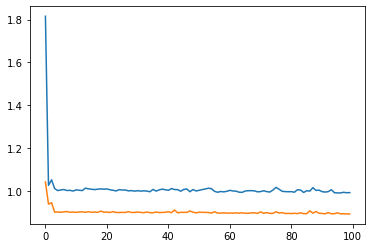

In [52]:
plt.plot(range(epochs), train_losses, range(epochs), val_losses)

In [53]:
model = LinearRegression(input_dim=1280, output_dim=1)
model.to(DEVICE)
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.MSELoss()
criterion.to(DEVICE, non_blocking=True)

train_loader, val_loader = get_split_loader(dataset_path, subset_list = ["train", "val"], embed_layer=33)

Loading esm1b_t33_650M_UR50S using 33 layer embedding


Using cache found in /home/t-fli/.cache/torch/hub/facebookresearch_esm_main
100%|██████████| 12/12 [04:22<00:00, 21.89s/it]
Using cache found in /home/t-fli/.cache/torch/hub/facebookresearch_esm_main


Loading esm1b_t33_650M_UR50S using 33 layer embedding


100%|██████████| 2/2 [00:29<00:00, 14.68s/it]


In [54]:
epochs = 100

train_losses, val_losses = train(
    model=model, train_loader=train_loader, val_loader=val_loader,
    device=DEVICE, criterion=criterion, learning_rate=learning_rate,
    epochs=epochs)

train_mse = test(
    model=model, loader=train_loader, device=DEVICE,
    criterion=criterion)

[   12] loss: 0.914



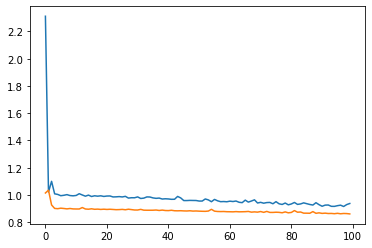

In [55]:
plt.plot(range(epochs), train_losses, range(epochs), val_losses)